In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

%matplotlib inline

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


### Step1. SentencePiece 설치하기

In [2]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


### Step2. SentencePiece 모델 학습

In [3]:
def tokenize(corpus):  # corpus: Tokenized Setence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

----------------------------------------

---- node 2 코드 ----

In [4]:
import os 
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, 'r') as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

Data Size: 76908


In [5]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

In [6]:
cleaned_corpus = list(set(raw)) 
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

----------

In [7]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Aug 16 05:20 korean_spm.model
-rw-r--r-- 1 root root 146213 Aug 16 05:20 korean_spm.vocab


In [8]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### Step 3. Tokenizer 함수 작성

In [9]:
def sp_tokenize(s, corpus):
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
    
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

### Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해보기

<해야할일>
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePice를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePice 모델의 model_type, vocab_size등을 변경해 가면서 성능 개선 여부 확인하기

In [10]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/GoingDeeper'

#### 0 필요한 패키지 전부 호출

#### 1 데이터
#### 1.1 데이터 다운로드

In [11]:
import requests

url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt'

with open('./data/ratings.txt', "wb") as file:
    res = requests.get(url)
    file.write(res.content)

#### 1.2 데이터 확인

In [12]:
import pandas as pd

df = pd.read_table('./data/ratings.txt', encoding='utf-8')
df.tail()

,id,document,label
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0
199999,8548411,포풍저그가나가신다영차영차영차,0


#### 1.3 데이터 전처리

In [13]:
# 결측치 확인
df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [14]:
df.label.unique()

array([1, 0])

In [15]:
df[df['label']==1].head()
# 레이블 0은 부정, 1은 긍정

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [16]:
df = df.dropna(how='any')
# len(df.dropna(how='any'))

In [17]:
df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [18]:
df.dtypes

id           int64
document    object
label        int64
dtype: object

In [19]:
df = df.drop_duplicates(['document'])
len(df)

194543

sum_len: 7011786
length: 15
문장의 최단 길이: 1
문장의 최장 길이: 150
문장의 평균 길이: 36


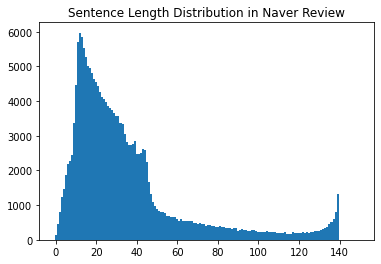

In [20]:
import matplotlib.pyplot as plt 

sum_len = 0

for sen in df['document']:
    length = len(sen)
#     print("length:", length)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
print("sum_len:", sum_len)
print("length:", length)

sentence_length = np.zeros((max_len), dtype=int)
# print("sentence_length:", sentence_length)
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)  # max_len이 150이 나오는 이유는 위에서 그렇게 지정해줬기 때문, 실제론 142
print("문장의 평균 길이:", sum_len//len(df['id']))


for sen in df['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution in Naver Review")
plt.show()

최대: 142
최소: 1
평균: 36.0423453940774


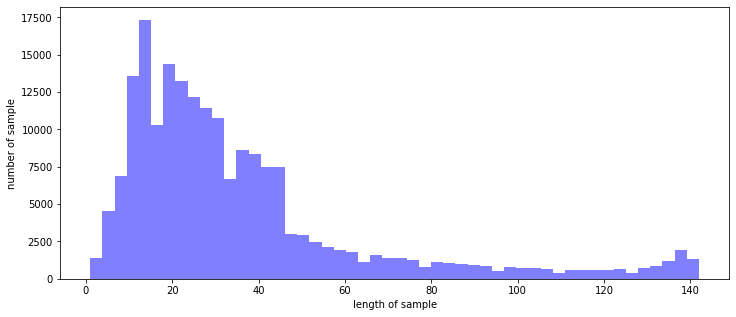

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def show_distribution(_df, key):
    total = list(map(lambda it: len(it), _df[key]))

    print(f'최대: {np.max(total)}')
    print(f'최소: {np.min(total)}')
    print(f'평균: {np.mean(total)}')

    plt.figure(figsize = (12,5))
    plt.hist(total, bins=50, alpha=0.5, color="b")
    plt.xlabel('length of sample')
    plt.ylabel('number of sample')
    plt.show()

show_distribution(df, 'document')

In [22]:
check_sentence_with_length(df['document'],  91)

너무너무재밌게보고있어요! 중간부터 본방사수했지만 스토리가 탄탄하고 흥미진진해서 1화부터 다찾아서 봤네요 배우들 연기도 어디하나빠지는데가없네요 요새는 수백향만챙겨봐요
이 영화 만드신 감독분이 저를 가르치셨던 교수님이신데 작품을 보지도 않고 장난식으로 글쓰는 거 보니 정말 기분이 나쁘군요. 영화 굉장히 좋습니다. 장난치지 맙시다.
정말 실제 일어나도 과언이 아닌 영화... 사상충처럼 자살을 하게 만드는 바이러스.. 무섭다.. 자연이 인간에게 해코지를 할 수 있는.. 논픽션인 영화로 봤습니다.
굉장한기대를가지고봤음에도불구하고 전혀실망이없었다. 2시간에가까운영화인데도 지루하지않고 미소가 떠나지않는영화였다. 저런인생을살고싶다라는생각이 정말 강하게 남는 영화다
내가 어린이였다면 토니와 같이 연잎을 밟으며 물 위를 뛰고 공중에서 사다리를 타는 꿈을 꿀 법한 영화. 어른이라서 그리 판타지로만 볼 수 없는 것이 조금 안타깝다.
몇번을 다시 봐도 2008년 제작된 애니라고 보기 어려울 정도...후속편을 기다리지만 기약이 없다...스토리와 연출을 그대로 일본애들이 했다는 사실이 참 부럽다..
그냥 시간떄우기용으로 봣는데..정말 너무너무 추천하고싶어요!!정말 재밋어요 ㅠㅠ 로코물의 정석을 보여주는듯 ㅎ 이영화를 통해서 불어의 매력도 함꼐 빠진듯해요 ㅎㅎㅎ
이 영화 보고 울었다.,.. 이런 명작 영화가 잘 안알려졌다는 건 정말 슬픈 일임... 리얼리티 있는 액션과 살아있는 감동.. 두마리 토끼를 다 잡은 남자들의 영화
넘 재밌게 잘 봤습니다 역시 포켓몬스터는 아이들을 천국으로 만들어주는것 같습니다 행복해하는 아이들을 보며 같이 보는 엄마도 넘 행복했습니다 넘 좋은 영화 감사합니다
솔직히 그래도 당일촬영해서 한건데 저정도면 완변한거죠;;그리고 재미게밧으면댓지 평점쓰는거보니깐 말이너무심하네 난잼있게밧는데신의선물14일 너무잼잇어요 끝낫지만 ㅜ ㅜ
오늘은 KBS2엔 재방하고 있는데, 하필이면 KBS1에 ...이유있는 결방이야 할수 없지만 잦은 결방이 시청자를 외면하게 만듭니다. 여기에 나오

In [23]:
check_sentence_with_length(df['document'],  1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [24]:
check_sentence_with_length(df['document'],  2)

쵝오
최고
좋아
흐흐
개쩜
굳뜨
좋다
섬뜩
♥♥
ㅎㅎ
대박
잼슴
굳굳
10
ㄹㄹ
윤하
유쾌
긋~
잼남
박수
수작
굳!
졸잼
꿈.
쏘우
굿!
명작
대작
잼네
맞아
ㅇㅇ
완벽
오우
굿굿
ㅠㅠ
굿잡
와우
..
좋네
無言
미투
gg
ㅋㅋ
후훗
걸작
잼잼
나두
예뻐
^^
만점
웃김
오호
설리
좋너
의읭
감동
원작
구ㄷ
하하
좋음
조앙
멋져
매력
개박
조음
추천
탁월
조아
쩔어
감독
가슴
재밋
잼씀
진리
붉다
눈물
오오
9점
zz
잼따
1등
짱임
홧팅
쳐봐
신고
짱♥
ㅡㅡ
역시
뻥임
섹시
명품
우정
짱~
동참
짱짱
야한
ㅊㅊ
굿~
대단
반담
만족


In [25]:
check_sentence_with_length(df['document'],  10)

내용이너무좋아요.ㅎ
뀰잼이다뀰잼이라구여
13살이엇냐?...
알파치노 연기때문에
이물감. 시 같았다
매력적인 영화...
이거 재밌는데...
.겁쟁이페달보고싶다
한국 영화치고 좋다
정말 멋진 결말!ㅎ
너무 잘 봣어요..
도라에몽 최고~!!
정말 재밋내요..굿
너무끔찍하네요ㅜㅜㅜ
유지태 너무 멌있다
진짜..쩔지..ㅜㅜ
개꿀재밋다뿌잉최고임
박보영 나와서 추천
그냥 재밌습니다^^
카이키는차캤습니다.
이거왜청불임????
소재가 새로웠던..
이거완전 추전!~~
1236547890
평점이왜이래....
조용하고 잔잔한영화
왜안 저스티스리그요
영화의매력에빠졌어요
피터팬너무좋아요ㅠㅠ
엄청재밌어요정의성굳
계속 울었다..ㅜㅜ
재밋다 그외는 없고
재미나요~귀여워요~
내가본한국최고의애니
인간은 자유의 노예
만세!!!!짱재밌음
아날로그적 감성..
완전 재밌다 ㅋㅋㅋ
유덕화아저씨잘생겼다
통일호 화장실 강추
구르재매맴잼잼잼잼젬
아직까지도 여운이.
스크림보다 재밌네!
좋았다.(열자..)
지극히 붉은 영화.
이거죠~이거!!!!
여운이너무많이남아요
스티브잡스가생각나요
제시카 알바 좋아요
정말 잘 만든 사극
나쁘지많은않은...
재밌네 이거 ㅋㅋㅋ
난 너무 재밌엇음~
보.고.싶.다.!!
즐겁게 볼수있었던!
Very good!
여자 걸그룹이 이쁨
7.32 라니 ㅋㅋ
전편 다보고싶다..
좋다~~ 사랑스러운
진짜감동이다감동이야
나는 재미있게 봤다
애니의새로운 개척점
감동이 있는 이야기
재미있게 봤어요^^
가나다라마바사아자차
좋아요정말좋아요정말
엄청재밌어요꼭보세요
정말 잘 만들어졌음
넝쿨째굴러온당신짱!
야하지만 좀 재밌다
정말대단한거같다는ㅋ
굿굿굿굿굯굿굿굿귯귯
이것도 꽤 명작이지
최고의 영화중 한편
잔잔한 멋이 있네요
겁나재밌었음!!!!
내인생최고의액션영화
감동의 물결....
볼만함~재밋음~굿굿
정말재밌게잘봤습니다
장근석존잘박신혜존예
솔직히 재밌다 ㅋㅋ
늘 감동이었네요..
배울점이많은영화ㅋㅋ
일주일만에 다봣다.
재미있게 본 영화~
멋지고 감동적이다.
너무 좋은 영화예요
이영아 넘 이뻐^^
붉은매다시보고싶다.

In [26]:
check_sentence_with_length(df['document'],  142)

영화 초반을 보면서 ' 좀 허항된 . 황당한 코믹스런 ' 연출이 되겠다란 생각을 하고 보기시작했는데 .. 연주가 처음 시작되는 부분에서 저도 모르게 눈가가 초촉해 지기시작하더군요 .. 이유는 모르겠네요 ... 자유에 대한 갈증과 박해에 대한 내용을 &gt


In [27]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 3000을 초과하는 문장 길이를 추출합니다.
    if _sum > 3000:
        print("Outlier Index:", idx+1)

Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35


In [28]:
def below_threshold_len(_df, key, max_len):
    total = df[key]
    _list = list(filter(lambda it: len(it) <= max_len, total))
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {len(_list)/len(total)}')

In [29]:
for _len in list(range(0, 142, 10)):
    below_threshold_len(df, 'document', _len)

전체 샘플 중 길이가 0 이하인 샘플의 비율: 0.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.0834057252124209
전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.35149555625234524
전체 샘플 중 길이가 30 이하인 샘플의 비율: 0.5596706126666084
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.717933824398719
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.8205640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.8586739178484962
전체 샘플 중 길이가 70 이하인 샘플의 비율: 0.8866523082300571
전체 샘플 중 길이가 80 이하인 샘플의 비율: 0.9084726769917191
전체 샘플 중 길이가 90 이하인 샘플의 비율: 0.9264995399474666
전체 샘플 중 길이가 100 이하인 샘플의 비율: 0.9405529882853663
전체 샘플 중 길이가 110 이하인 샘플의 비율: 0.9519849082208046
전체 샘플 중 길이가 120 이하인 샘플의 비율: 0.9620289601784695
전체 샘플 중 길이가 130 이하인 샘플의 비율: 0.9730239587134978
전체 샘플 중 길이가 140 이하인 샘플의 비율: 0.9999948597482304


In [30]:
df = df[df['document'].apply(lambda ch: len(ch) >= 10)]
df = df[df['document'].apply(lambda ch: len(ch) <= 70)]

최대: 70
최소: 10
평균: 28.825650662407217


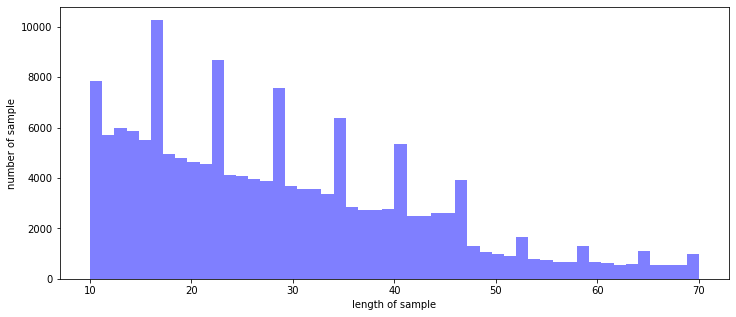

In [31]:
show_distribution(df, 'document')

#### 2 모델 설계 및 학습

In [32]:
models = {}

for model_type in ['unigram', 'bpe', 'char', 'word']:
    for vocab_size in [2000, 4000, 6000, 8000, 10000]:
        
        model_prefix = f'{model_type}_{str(vocab_size // 1000) + "k"}'
        models[model_prefix] = {}
        
        models[model_prefix]['model_type'] = model_type
        models[model_prefix]['vocab_size'] = vocab_size

models

{'unigram_2k': {'model_type': 'unigram', 'vocab_size': 2000},
 'unigram_4k': {'model_type': 'unigram', 'vocab_size': 4000},
 'unigram_6k': {'model_type': 'unigram', 'vocab_size': 6000},
 'unigram_8k': {'model_type': 'unigram', 'vocab_size': 8000},
 'unigram_10k': {'model_type': 'unigram', 'vocab_size': 10000},
 'bpe_2k': {'model_type': 'bpe', 'vocab_size': 2000},
 'bpe_4k': {'model_type': 'bpe', 'vocab_size': 4000},
 'bpe_6k': {'model_type': 'bpe', 'vocab_size': 6000},
 'bpe_8k': {'model_type': 'bpe', 'vocab_size': 8000},
 'bpe_10k': {'model_type': 'bpe', 'vocab_size': 10000},
 'char_2k': {'model_type': 'char', 'vocab_size': 2000},
 'char_4k': {'model_type': 'char', 'vocab_size': 4000},
 'char_6k': {'model_type': 'char', 'vocab_size': 6000},
 'char_8k': {'model_type': 'char', 'vocab_size': 8000},
 'char_10k': {'model_type': 'char', 'vocab_size': 10000},
 'word_2k': {'model_type': 'word', 'vocab_size': 2000},
 'word_4k': {'model_type': 'word', 'vocab_size': 4000},
 'word_6k': {'model_ty

#### 2.1 sentencepiece 모델 학습

In [33]:
import sentencepiece as spm

def TrainSentencePiece(model_prefix, model_type='unigram', vocab_size = 8000):
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix={} --model_type={} --vocab_size={}'.format(
            temp_file, model_prefix, model_type, vocab_size)    
    ) 
    return tensor, word_index, index_word

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def Text_ClassifierModel(model_prefix):
    tensor, word_index, index_word = sp_tokenize(s, df['document'])
    x_train, x_val, y_train, y_val = train_test_split(tensor, df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)



    word_vector_dim = 32

    model = Sequential()
    model.add(Embedding(vocab_size, word_vector_dim))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    epochs=20
    batch_size=64

    history = model.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(x_val,y_val), callbacks=es, verbose=1)

    
Text_ClassifierModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1597/1597 [==============================] - 13s 6ms/step - loss: 0.6562 - accuracy: 0.6156 - val_loss: 0.6449 - val_accuracy: 0.6547
Epoch 2/20
1597/1597 [==============================] - 9s 6ms/step - loss: 0.6757 - accuracy: 0.5542 - val_loss: 0.6950 - val_accuracy: 0.5005
Epoch 3/20
1597/1597 [==============================] - 9s 6ms/step - loss: 0.6940 - accura

In [35]:
result_spm = model.evaluate(x_test, y_test, verbose=0)

In [36]:
result_spm

[0.6936520934104919, 0.4942452311515808]

In [37]:
for key in models:
    if f'{key}.model' not in os.listdir('./'):
        print(f'#### {key} sentence piece model train start')
        TrainSentencePiece(
            model_prefix=key, 
            model_type=models[key]['model_type'], 
            vocab_size=models[key]['vocab_size'])
        print(f'#### {key} sentence piece model train end')
#         break
#     break
# break

#### koNLPy의 Mecab 모델

In [38]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def data_load(num_words=10000):
    
    x_train, x_val, y_train, y_val = train_test_split(df['document'], df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

In [39]:
x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()

In [40]:
index_to_word = { index: word for word, index in word_to_index.items() }

In [41]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

x_train.shape, x_test.shape, x_val.shape

((102172, 70), (25544, 70), (31929, 70))

In [42]:
y_train.shape, y_test.shape, y_val.shape

((102172,), (25544,), (31929,))

In [43]:
vocab_size = len(word_to_index)
word_vector_dim = 128

In [44]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [45]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

epochs=20
batch_size=64

history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=es, verbose=1)

Epoch 1/20
1597/1597 [==============================] - 11s 6ms/step - loss: 0.3840 - accuracy: 0.8265 - val_loss: 0.3376 - val_accuracy: 0.8528
Epoch 2/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2963 - accuracy: 0.8727 - val_loss: 0.3209 - val_accuracy: 0.8587
Epoch 3/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2506 - accuracy: 0.8949 - val_loss: 0.3270 - val_accuracy: 0.8572
Epoch 4/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2140 - accuracy: 0.9120 - val_loss: 0.3490 - val_accuracy: 0.8568
Epoch 5/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.1796 - accuracy: 0.9279 - val_loss: 0.3927 - val_accuracy: 0.8524
Epoch 6/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.1493 - accuracy: 0.9409 - val_loss: 0.4521 - val_accuracy: 0.8466
Epoch 00006: early stopping


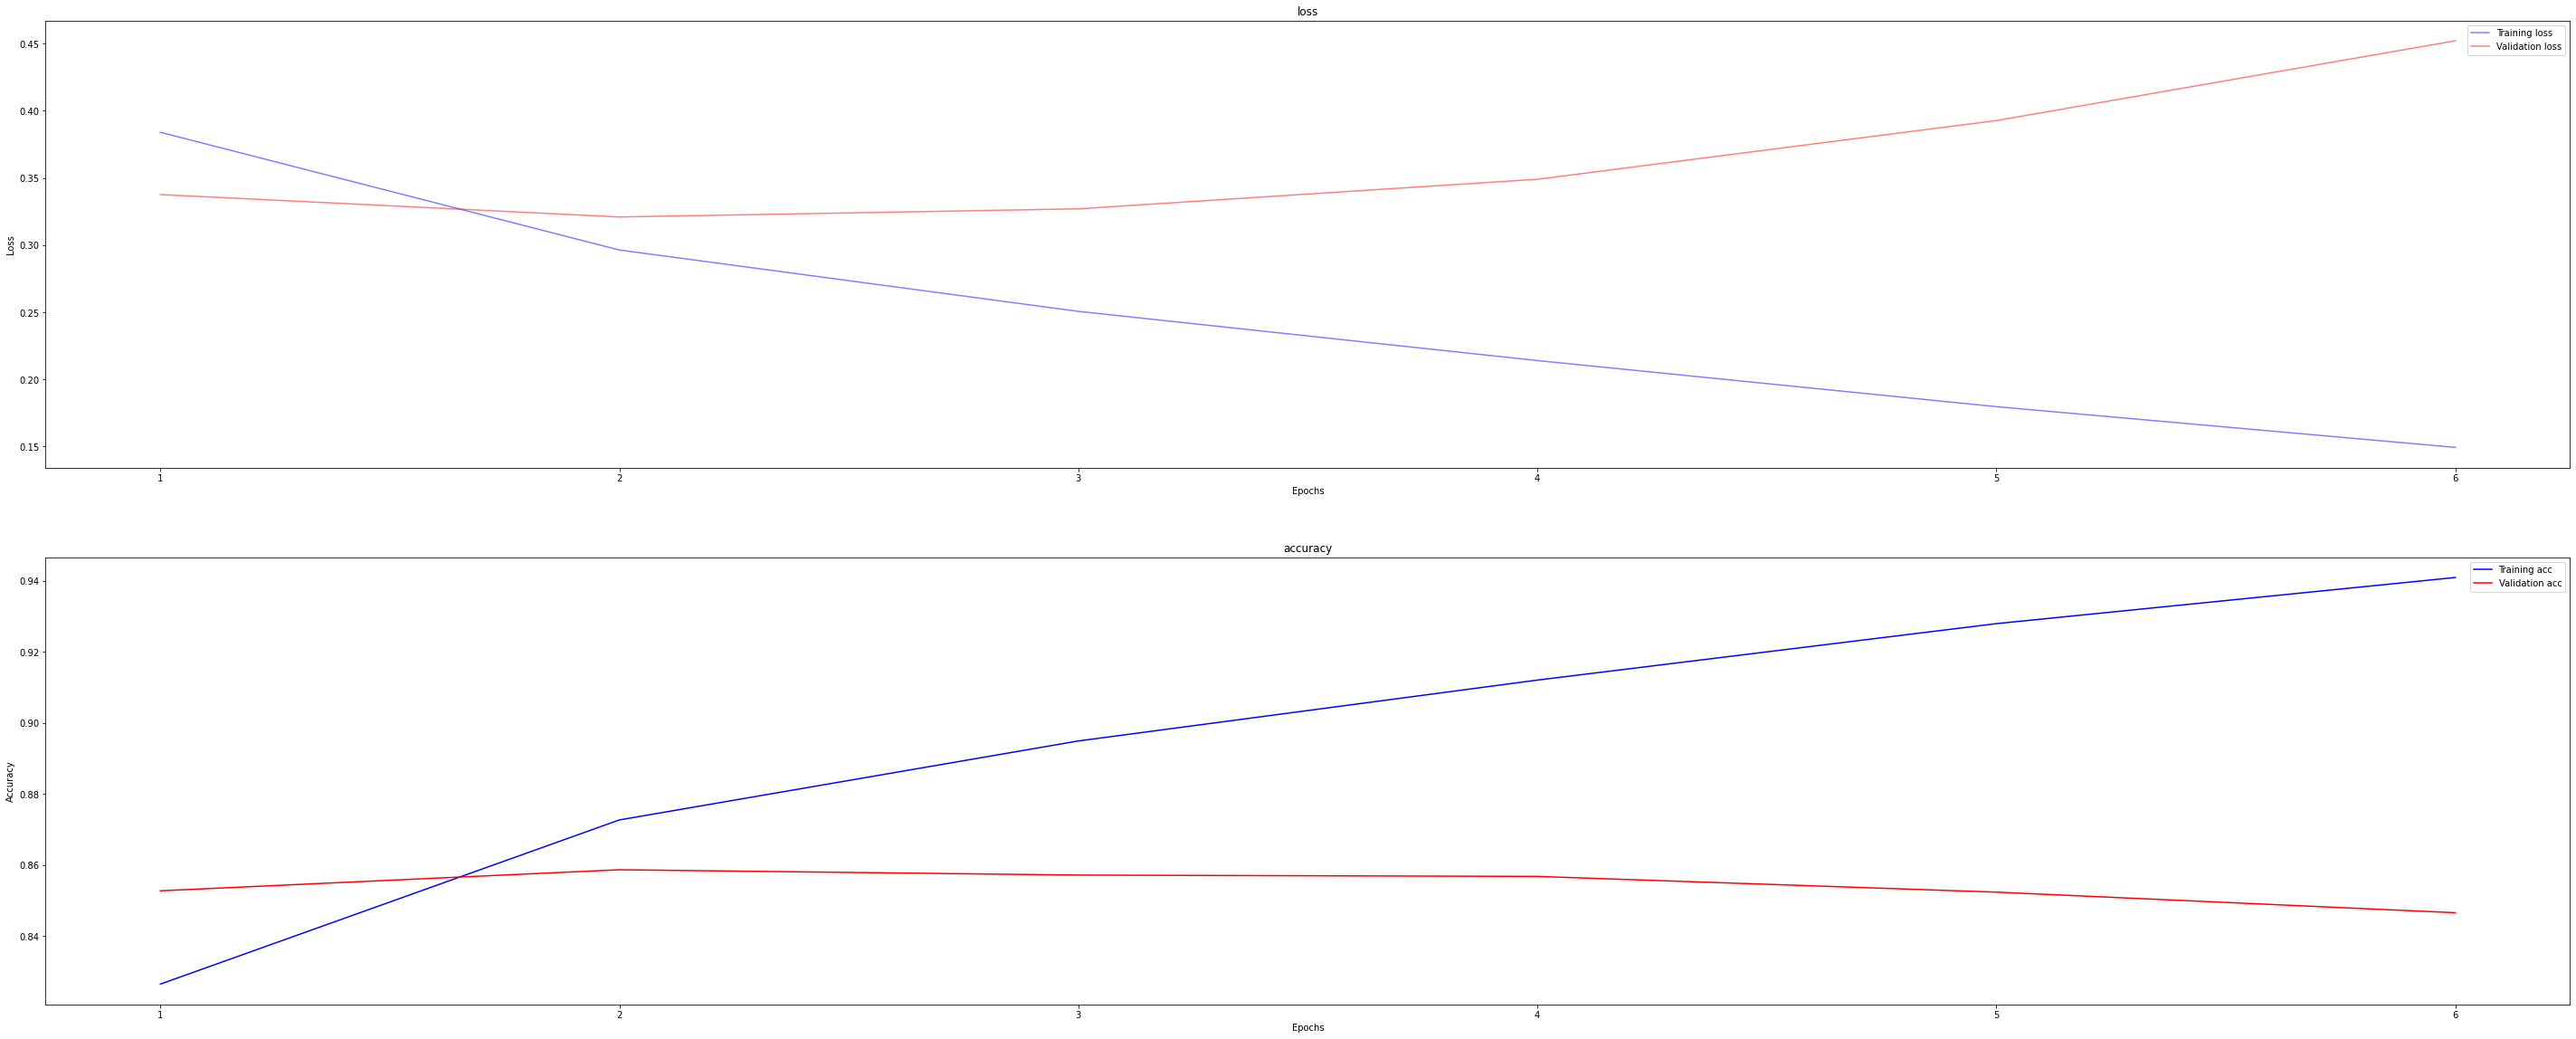

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(50, 20))

epochs = range(1, len(history.history['loss']) + 1)

ax[0].plot(epochs, history.history['loss'], 'b', alpha=0.5, label='Training loss')
ax[0].plot(epochs, history.history['val_loss'], 'r', alpha=0.5, label='Validation loss')
ax[0].set_title(f'loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], 'b', label='Training acc')
ax[1].plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
ax[1].set_title(f'accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
    
plt.show()


In [47]:
result_mecab = model.evaluate(x_test, y_test, verbose=1)

799/799 [==============================] - 2s 3ms/step - loss: 0.4530 - accuracy: 0.8459


In [48]:
result_spm, result_mecab

# 정확도 80%이상은 넘김

([0.6936520934104919, 0.4942452311515808],
 [0.45301252603530884, 0.8458737730979919])

In [50]:
%%time
# spm.SentencePieceTrainer.Train()

TrainSentencePiece('./unigram_8k.model', model_type='unigram', vocab_size=8000)

CPU times: user 46.2 s, sys: 0 ns, total: 46.2 s
Wall time: 20 s


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=./unigram_8k.model --model_type=unigram --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ./unigram_8k.model
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab

(array([[ 549,  666, 1817, ...,    0,    0,    0],
        [   4, 5810,   47, ...,    0,    0,    0],
        [   4,   26,    3, ...,    0,    0,    0],
        ...,
        [2092,  684,  314, ...,    0,    0,    0],
        [3395,  444,  295, ...,    0,    0,    0],
        [ 490, 3214,  536, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '.': 3,
  '▁': 4,
  '을': 5,
  '의': 6,
  '에': 7,
  '이': 8,
  '를': 9,
  '는': 10,
  '가': 11,
  '은': 12,
  ',': 13,
  '고': 14,
  '에서': 15,
  '로': 16,
  '한': 17,
  '▁“': 18,
  '인': 19,
  '”': 20,
  '일': 21,
  ')': 22,
  '(': 23,
  '과': 24,
  '▁이': 25,
  '와': 26,
  '으로': 27,
  '▁있다': 28,
  '지': 29,
  '도': 30,
  '▁수': 31,
  '할': 32,
  '했다': 33,
  '▁밝혔다': 34,
  '▁말했다': 35,
  '하고': 36,
  '년': 37,
  '다': 38,
  '하는': 39,
  '▁있는': 40,
  '기': 41,
  '리': 42,
  '▁그': 43,
  '자': 44,
  '▁전': 45,
  '며': 46,
  '스': 47,
  '해': 48,
  '▁2': 49,
  '▁그는': 50,
  '▁1': 51,
  '만': 52,
  '▁대한': 53,
  '된': 54,
  '▁위해': 55,
  '월': 56,
  '▁전했다': 57

In [51]:
TrainSentencePiece('./unigram_2k.model', model_type='unigram', vocab_size=2000)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=./unigram_2k.model --model_type=unigram --vocab_size=2000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ./unigram_2k.model
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab

(array([[ 549,  666, 1817, ...,    0,    0,    0],
        [   4, 5810,   47, ...,    0,    0,    0],
        [   4,   26,    3, ...,    0,    0,    0],
        ...,
        [2092,  684,  314, ...,    0,    0,    0],
        [3395,  444,  295, ...,    0,    0,    0],
        [ 490, 3214,  536, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '.': 3,
  '▁': 4,
  '을': 5,
  '의': 6,
  '에': 7,
  '이': 8,
  '를': 9,
  '는': 10,
  '가': 11,
  '은': 12,
  ',': 13,
  '고': 14,
  '에서': 15,
  '로': 16,
  '한': 17,
  '▁“': 18,
  '인': 19,
  '”': 20,
  '일': 21,
  ')': 22,
  '(': 23,
  '과': 24,
  '▁이': 25,
  '와': 26,
  '으로': 27,
  '▁있다': 28,
  '지': 29,
  '도': 30,
  '▁수': 31,
  '할': 32,
  '했다': 33,
  '▁밝혔다': 34,
  '▁말했다': 35,
  '하고': 36,
  '년': 37,
  '다': 38,
  '하는': 39,
  '▁있는': 40,
  '기': 41,
  '리': 42,
  '▁그': 43,
  '자': 44,
  '▁전': 45,
  '며': 46,
  '스': 47,
  '해': 48,
  '▁2': 49,
  '▁그는': 50,
  '▁1': 51,
  '만': 52,
  '▁대한': 53,
  '된': 54,
  '▁위해': 55,
  '월': 56,
  '▁전했다': 57

In [52]:
TrainSentencePiece('./bpe_8k.model', model_type='bpe', vocab_size=8000)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=./bpe_8k.model --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: ./bpe_8k.model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_

(array([[ 549,  666, 1817, ...,    0,    0,    0],
        [   4, 5810,   47, ...,    0,    0,    0],
        [   4,   26,    3, ...,    0,    0,    0],
        ...,
        [2092,  684,  314, ...,    0,    0,    0],
        [3395,  444,  295, ...,    0,    0,    0],
        [ 490, 3214,  536, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '.': 3,
  '▁': 4,
  '을': 5,
  '의': 6,
  '에': 7,
  '이': 8,
  '를': 9,
  '는': 10,
  '가': 11,
  '은': 12,
  ',': 13,
  '고': 14,
  '에서': 15,
  '로': 16,
  '한': 17,
  '▁“': 18,
  '인': 19,
  '”': 20,
  '일': 21,
  ')': 22,
  '(': 23,
  '과': 24,
  '▁이': 25,
  '와': 26,
  '으로': 27,
  '▁있다': 28,
  '지': 29,
  '도': 30,
  '▁수': 31,
  '할': 32,
  '했다': 33,
  '▁밝혔다': 34,
  '▁말했다': 35,
  '하고': 36,
  '년': 37,
  '다': 38,
  '하는': 39,
  '▁있는': 40,
  '기': 41,
  '리': 42,
  '▁그': 43,
  '자': 44,
  '▁전': 45,
  '며': 46,
  '스': 47,
  '해': 48,
  '▁2': 49,
  '▁그는': 50,
  '▁1': 51,
  '만': 52,
  '▁대한': 53,
  '된': 54,
  '▁위해': 55,
  '월': 56,
  '▁전했다': 57

1160 all=127264 active=8337 piece=국의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=397 size=1180 all=128061 active=9134 piece=▁부인
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=393 size=1200 all=128731 active=9804 piece=▁백악관
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=393 min_freq=61
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=388 size=1220 all=129605 active=7298 piece=▁충돌
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=384 size=1240 all=130293 active=7986 piece=▁수감
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=377 size=1260 all=130992 active=8685 piece=합니다
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=371 size=1280 all=131855 active=9548 piece=▁이상의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=365 size=1300 all=132534 active=10227 piece=▁이전
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=365 min_freq=58
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=360 size=1320 all=133153 active=7219 piece=▁사망했다
bpe_model_trainer.cc(258) 

In [53]:
TrainSentencePiece('./char_8k.model', model_type='char', vocab_size=8000)

x_freq=67 min_freq=21
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=67 size=5720 all=214172 active=10906 piece=카르타
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=67 size=5740 all=214286 active=11020 piece=▁뉴욕에서
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=66 size=5760 all=214415 active=11149 piece=뉴스
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=66 size=5780 all=214838 active=11572 piece=▁55
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=66 size=5800 all=215100 active=11834 piece=샤라포
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=66 min_freq=21
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=66 size=5820 all=215130 active=10783 piece=마빈라덴
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=65 size=5840 all=215388 active=11041 piece=아프
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=65 size=5860 all=215679 active=11332 piece=▁비공
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=65 size=5880 all=215966 active=11619 p

(array([[ 549,  666, 1817, ...,    0,    0,    0],
        [   4, 5810,   47, ...,    0,    0,    0],
        [   4,   26,    3, ...,    0,    0,    0],
        ...,
        [2092,  684,  314, ...,    0,    0,    0],
        [3395,  444,  295, ...,    0,    0,    0],
        [ 490, 3214,  536, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '.': 3,
  '▁': 4,
  '을': 5,
  '의': 6,
  '에': 7,
  '이': 8,
  '를': 9,
  '는': 10,
  '가': 11,
  '은': 12,
  ',': 13,
  '고': 14,
  '에서': 15,
  '로': 16,
  '한': 17,
  '▁“': 18,
  '인': 19,
  '”': 20,
  '일': 21,
  ')': 22,
  '(': 23,
  '과': 24,
  '▁이': 25,
  '와': 26,
  '으로': 27,
  '▁있다': 28,
  '지': 29,
  '도': 30,
  '▁수': 31,
  '할': 32,
  '했다': 33,
  '▁밝혔다': 34,
  '▁말했다': 35,
  '하고': 36,
  '년': 37,
  '다': 38,
  '하는': 39,
  '▁있는': 40,
  '기': 41,
  '리': 42,
  '▁그': 43,
  '자': 44,
  '▁전': 45,
  '며': 46,
  '스': 47,
  '해': 48,
  '▁2': 49,
  '▁그는': 50,
  '▁1': 51,
  '만': 52,
  '▁대한': 53,
  '된': 54,
  '▁위해': 55,
  '월': 56,
  '▁전했다': 57

In [54]:
TrainSentencePiece('./word_8k.model', model_type='word', vocab_size=8000)

(array([[ 549,  666, 1817, ...,    0,    0,    0],
        [   4, 5810,   47, ...,    0,    0,    0],
        [   4,   26,    3, ...,    0,    0,    0],
        ...,
        [2092,  684,  314, ...,    0,    0,    0],
        [3395,  444,  295, ...,    0,    0,    0],
        [ 490, 3214,  536, ...,    0,    0,    0]], dtype=int32),
 {'<unk>': 0,
  '<s>': 1,
  '</s>': 2,
  '.': 3,
  '▁': 4,
  '을': 5,
  '의': 6,
  '에': 7,
  '이': 8,
  '를': 9,
  '는': 10,
  '가': 11,
  '은': 12,
  ',': 13,
  '고': 14,
  '에서': 15,
  '로': 16,
  '한': 17,
  '▁“': 18,
  '인': 19,
  '”': 20,
  '일': 21,
  ')': 22,
  '(': 23,
  '과': 24,
  '▁이': 25,
  '와': 26,
  '으로': 27,
  '▁있다': 28,
  '지': 29,
  '도': 30,
  '▁수': 31,
  '할': 32,
  '했다': 33,
  '▁밝혔다': 34,
  '▁말했다': 35,
  '하고': 36,
  '년': 37,
  '다': 38,
  '하는': 39,
  '▁있는': 40,
  '기': 41,
  '리': 42,
  '▁그': 43,
  '자': 44,
  '▁전': 45,
  '며': 46,
  '스': 47,
  '해': 48,
  '▁2': 49,
  '▁그는': 50,
  '▁1': 51,
  '만': 52,
  '▁대한': 53,
  '된': 54,
  '▁위해': 55,
  '월': 56,
  '▁전했다': 57